TESSERACT

In [4]:
import cv2
import pytesseract
from pytesseract import Output
import re
import matplotlib.pyplot as plt

def crop_and_gray(img_path):

    img = cv2.imread(img_path)

    #crop part
    h, w = img.shape[:2]
    if w >= h:
        img = img[0:h,0:int(w/(1.1*(w/h)))]
    else:
        img = img[0:int(h/(1.1*(h/w))), 0:w]
        
    #grayscale part
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rot_data = pytesseract.image_to_osd(gray)

    #rotation part
    print("[OSD] "+rot_data)
    rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
    angle = float(rot)
    if angle > 0:
        angle = 360 - angle
        # print("[ANGLE] "+str(angle))
        
    #rotate the image to deskew it
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

img_path = r"C:\Users\Nigel\Desktop\tatneft\test4.jpg"
rotated = crop_and_gray(img_path)

[OSD] Page number: 0
Orientation in degrees: 0
Rotate: 0
Orientation confidence: 23.25
Script: Cyrillic
Script confidence: 14.67



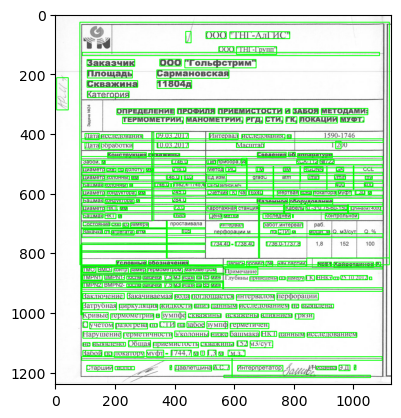

In [6]:
def get_predictions(prepared_image):
    """
    Желательно подавать готовое изображение (обрезанное и черно-белое)
    """
    d = pytesseract.image_to_data(prepared_image, output_type=Output.DICT, lang='rus')

    rgb = cv2.cvtColor(prepared_image, cv2.COLOR_GRAY2RGB)
    # print(d.keys())

    bboxes = []
    texts = []
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) >= 40:#cofidence
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            # print(f"{x} {y} {x+w} {y+h}")
            bboxes.append([x, y, x + w, y + h])
            texts.append(d['text'][i])
            rgb = cv2.rectangle(rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return rgb, bboxes, texts

image, bboxes, texts = get_predictions(rotated)

#СОЗДАТЬ txt файлы с ббоксами и лейблами-----
with open('bboxes.txt', 'w') as f:
    for bbox in bboxes:
        f.write('\t'.join(map(str, bbox))+'\n')

with open('texts.txt', 'w') as f:
    for label in texts:
        f.write(label+ '\n')

# cv2.imwrite("inference1.jpg", image)

plt.imshow(image)